In [1]:
# Author: John Maxwell
# Date: 2018-03-30
# TLDR: Simple heuristic to anonymize entities
# =============================================================================
import codecs
import string
import sys
import numpy as np
import pandas as pd
import spacy
from spacy.lang.en import English
from spacy.tokens import Doc, Span, Token
from tqdm import tqdm


class SimpleEntityAnonymizer(object):
    """Spacy pipeline component. Used to to replace entities with anonymized tokens.
    If a word is capitalized and doesn't appear in lowercase elsewhere in the text anonymize it."""

    name = 'entity_anonymizer'

    def __init__(self, nlp, attr='entity_id'):
        Token.set_extension(attr, default=None)

    def __call__(self, doc):
        upper = set()
        lower = set()
        entity_map = dict()

        for token in doc:
            if token.text[0] in string.ascii_uppercase:
                upper.add(token.text)
            else:
                lower.add(token.text)

        entities = [token for token in upper if token.lower() not in lower]
        entity_ids = np.random.choice(len(entities), len(entities)).tolist()
        
        for token in doc:
            if token.text in entities:
                if token.text not in entity_map.keys():
                    entity_map[token.text] = '@entity' + str(entity_ids.pop())
                token._.set('entity_id', entity_map[token.text])
                
        return doc


def entity_doc_to_text(doc):
    """Prints out text with anonymized tokens.

    :param doc: spacy doc object
    :return: anonymized text
    """
    # spacy issue #2073
    # if not doc[0].has_extension('entity_id'):
    #     print('Tokens don\'t have attribute: entity_id')
    #     return None
    entid2w = dict()
    w2entid = dict()
    text = ''
    for token in doc:
        if token._.entity_id is not None:
            whitespace = token.text_with_ws[len(token.text):]
            text += token._.entity_id + whitespace
            entid2w[token._.entity_id] = token.text
            w2entid[token.text] = token._.entity_id
        else:
            text += token.text_with_ws
    return text, entid2w, w2entid

In [2]:
docs_index = pd.read_csv('../../data/documents_books.csv')
questions = pd.read_csv('../../data/questions_books_who.csv')

In [3]:
summaries = pd.read_csv('../../data/third_party/wikipedia/summaries.csv')
questions = questions.merge(summaries.loc[:, ['document_id', 'summary',  'summary_tokenized']], how='left', on='document_id')

In [4]:
import pickle
import re
from collections import Counter

nlp_simple = spacy.load('en_core_web_md', diable=['tagger', 'parser', 'ner', 'textcat'])

nlp = English()
component = SimpleEntityAnonymizer(nlp)
nlp.add_pipe(component, last=True)

In [13]:
entity_id_translation = dict()
previous_doc_id = ''

for i, row in tqdm(questions.iterrows(), total=len(questions)):
    if row['document_id'] != previous_doc_id:
        previous_doc_id = row['document_id']
        doc = nlp(row['summary'])
        new_text, entid2w, w2entid = entity_doc_to_text(doc)
        entity_id_translation[row['document_id']] = {'entid2w': entid2w, 'w2entid': w2entid}
        doc = nlp_simple(new_text)
    
    q = nlp_simple(row['question'])
    q_tokenized = ' '.join([token.text for token in q])
    q_tokenized = re.sub('[\s]+', ' ', q_tokenized)
    
    best_similarity_score = 0.0
    best_sent_triple = ''

    sent_stack = []
    for sent in doc.sents:
        # create groups of 3 sentences
        sent_stack.append(sent)
        if len(sent_stack) >= 3:
            sent_triple = doc[sent_stack[0].start:sent_stack[-1].end]
            sent_stack.pop(0)

            similarity_score = sent_triple.similarity(q)
            if similarity_score > best_similarity_score:
                best_similarity_score = similarity_score
                best_sent_triple = ' '.join([token.text for token in sent_triple])
    
    with codecs.open('../../data/summary_anon_{}.q'.format(row['set']), 'a', 
                     encoding='utf-8', errors='ignore') as f:
        best = re.sub('[\s]+', ' ', best_sent_triple).strip()
        f.write(best + ' <d> ' + q_tokenized + '\n')
        
    with codecs.open('../../data/summary_anon_{}.a'.format(row['set']), 'a', 
                     encoding='utf-8', errors='ignore') as f:
        answer_tokens = row['answer1_tokenized'].split()
        answer_tokens_output = []
        for token in answer_tokens:
            if token in w2entid:
                answer_tokens_output.append(w2entid[token])
            else:
                answer_tokens_output.append(token)
        answer_tokens_output = ' '.join(answer_tokens_output).strip()
        f.write(answer_tokens_output + '\n')
        
with open('../../data/summary_entity_id_translation.pkl', 'wb') as f:
    pickle.dump(entity_id_translation, f)

100%|██████████████████████████████████████| 5707/5707 [06:12<00:00, 15.31it/s]


In [38]:
def create_vocab(question_file, answer_file, out_file):
    with codecs.open(question_file, 'r', encoding='utf-8', errors='ignore') as f:
        q_tokens = f.readlines()
    with codecs.open(answer_file, 'r', encoding='utf-8', errors='ignore') as f:
        a_tokens = f.readlines()
        
    counts = Counter()
    for q_line, a_line in zip(q_tokens, a_tokens):
        for qt, at in zip(q_line.split(), a_line.split()):
            if len(qt.strip()) != 0:
                counts[qt.strip()] += 1
            if len(at.strip()) != 0:
                counts[at.strip()] += 1
            
    with codecs.open(out_file, 'w', encoding='utf-8', errors='ignore') as f:
        for word, count in counts.most_common():
            f.write('{}\n'.format(word))

In [39]:
from preshed.counter import PreshCounter

create_vocab('../../data/summary_anon_train.q',
             '../../data/summary_anon_train.a',
             '../../data/vocab_summary_ent_train.q')

create_vocab('../../data/summary_anon_valid.q',
             '../../data/summary_anon_valid.a',
             '../../data/vocab_summary_ent_valid.q')

create_vocab('../../data/summary_anon_test.q',
             '../../data/summary_anon_test.a',
             '../../data/vocab_summary_ent_test.q')

In [41]:
with codecs.open('../../data/summary_anon_train.q', 'r', encoding='utf-8', errors='ignore') as f:
    q_tokens = f.readlines()
with codecs.open('../../data/summary_anon_train.a', 'r', encoding='utf-8', errors='ignore') as f:
    a_tokens = f.readlines()

counts = Counter()
for q_line, a_line in zip(q_tokens, a_tokens):
    for qt, at in zip(q_line.split(), a_line.split()):
        if len(qt.strip()) != 0:
            counts[qt.strip()] += 1
        if len(at.strip()) != 0:
            counts[at.strip()] += 1

counts.most_common(20)

[('.', 1362),
 ('The', 1038),
 (',', 814),
 ('the', 800),
 ('and', 498),
 ('is', 484),
 ('of', 438),
 ('@entity2', 367),
 ('@entity0', 360),
 ('a', 356),
 ('@entity7', 356),
 ('@entity5', 342),
 ('@entity4', 337),
 ('to', 336),
 ('@entity10', 322),
 ('He', 321),
 ('@entity6', 319),
 ('@entity8', 314),
 ('@entity3', 310),
 ('@entity1', 309)]

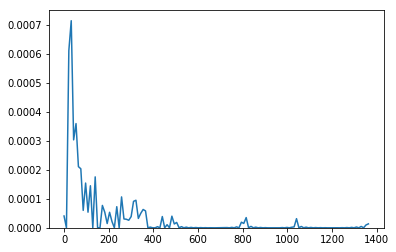

In [45]:
import seaborn as sns

asdf = [j for i,j in counts.most_common()]
sns.distplot(asdf, hist=False)